In [1]:
# example of calculating the receptive field for the PatchGAN

# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


In [2]:
%matplotlib inline

# example of pix2pix gan for satellite to map image-to-image translation
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

from os import listdir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

## similar to this load array

def load_file_names(path):
    
    path1="/Day/"
    path2="/Night_p/"
    
    file_names=listdir(path+path1)
    
#     print(len(file_names))
    
#     print(file_names[0])

    file_names=file_names[:30]
    
    print(len(file_names))
    
    
    
    
    
    dataset_array=[]
    
#     src_path_array=[]
    
#     target_path_array=[]
    
    for name in file_names:
        src_path=path+path1+name
        target_path=path+path2+name.replace("day","night")
        
#         img=mpimg.imread(src_path)
#         imgplot = plt.imshow(img)
#         plt.show()
        
#         img2=mpimg.imread(target_path)
#         imgplot = plt.imshow(img2)
#         plt.show()
        
#         break

        dataset_array.append([src_path,target_path])
    
    
    return dataset_array
    
    
def generate_real_samples_v2(dataset,n_samples,patch_shape):
    
    ix=randint(0,len(dataset),n_samples)
    
    source_file_names=[]
    dest_file_names=[]
    
    for i in ix:
        source_file_names.append(dataset[i][0])
        dest_file_names.append(dataset[i][1])
    
    X1 = np.array([np.array(Image.open(fname)) for fname in source_file_names])
    X2 = np.array([np.array(Image.open(fname)) for fname in dest_file_names])
    
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5

    
#     print(X1.shape)
#     print(X2.shape)
    
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
    
    
    


# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples_v2(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
# 	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(dataset) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples_v2(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		if (i+1) % 100 == 0:
			
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)
			# print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
            
            
            
            

# # load image data
# dataset = load_real_samples('maps_256.npz')
# print('Loaded', dataset[0].shape, dataset[1].shape)
# # define input shape based on the loaded dataset
fnam="./night2day/train_divided/Day/1_49_to_1day.jpg"
fname2="./night2day/train_divided/Day/1_49_to_2day.jpg"

fnames=[fnam,fname2]
image_shape = np.array([np.array(Image.open(fname)) for fname in fnames]).shape[1:]
# # define the models
d_model = define_discriminator(image_shape)
# g_model = define_generator(image_shape)
# # define the composite model
# gan_model = define_gan(g_model, d_model, image_shape)
# # train model
# train(d_model, g_model, gan_model, dataset)

dataset_array=load_file_names("./night2day/train_divided")

print("Loaded dataset")

# print(len(dataset_array[0]))

# n_samples=8

# generate_real_samples_v2(dataset_array, n_samples, d_model.output_shape[1])

# # load image data
# dataset = load_real_samples('maps_256.npz')
# print('Loaded', dataset[0].shape, dataset[1].shape)
# # define input shape based on the loaded dataset
# image_shape = dataset[0].shape[1:]
# # define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
# train(d_model, g_model, gan_model, dataset_array)

Using TensorFlow backend.
c:\users\laxman\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\laxman\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\laxman\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
30
Loaded dataset


(2, 256, 256, 3)
(2, 256, 256, 3)


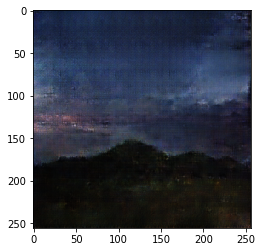

In [5]:
# example of loading a pix2pix model and using it for image to image translation
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from PIL import Image
import numpy as np

import os

import matplotlib 


test_images=[]

for im in os.listdir("./test_data/"):
    
    test_images.append("./test_data/"+im)
    


image_shape = np.array([np.array(Image.open(fname).resize((256, 256), Image.ANTIALIAS)) for fname in test_images]).shape[1:]


src_image = np.array([np.array(Image.open(fname).resize((256, 256), Image.ANTIALIAS)) for fname in test_images])

src_image = (src_image - 127.5) / 127.5
#     X2 = (X2 - 127.5) / 127.5

model = load_model('./model_050000.h5')

# generate image from source
gen_image = model.predict(src_image)

gen_image =(gen_image + 1) / 2.0

# gen_image =gen_image*255 

print(gen_image.shape)

# # plot source, generated and target images
# def plot_images(src_img, gen_img, tar_img):
# 	images = vstack((src_img, gen_img, tar_img))
# 	# scale from [-1,1] to [0,1]
# 	images = (images + 1) / 2.0
# 	titles = ['Source', 'Generated', 'Expected']
# 	# plot images row by row
# 	for i in range(len(images)):
# 		# define subplot
# 		pyplot.subplot(1, 3, 1 + i)
# 		# turn off axis
# 		pyplot.axis('off')
# 		# plot raw pixel data
# 		pyplot.imshow(images[i])
# 		# show title
# 		pyplot.title(titles[i])
# 	pyplot.show()
 

# img = Image.fromarray((gen_image[0] * 255).astype(np.uint8))
print(gen_image.shape)

for i in range(len(gen_image)):
    

    pyplot.imshow(gen_image[i])

    matplotlib.image.imsave(test_images[i].replace("./test_data/","./test_out/"), gen_image[i])

#     im = Image.fromarray(gen_image[i])
#     im.save(test_images[i].replace("./test_data/","./test_out/"))



Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>100, d1[0.164] d2[0.220] g[9.929]
>200, d1[0.085] d2[0.321] g[13.221]
>300, d1[0.081] d2[0.140] g[10.602]
>400, d1[0.027] d2[0.081] g[18.050]
>500, d1[0.272] d2[0.160] g[11.148]
>600, d1[0.145] d2[0.294] g[9.737]
>700, d1[0.035] d2[0.126] g[14.967]
>800, d1[0.311] d2[0.278] g[10.511]
>900, d1[0.004] d2[0.049] g[19.478]
>1000, d1[0.045] d2[0.059] g[18.665]
>1100, d1[0.003] d2[0.068] g[12.538]
>1200, d1[0.127] d2[0.333] g[9.541]
>1300, d1[0.019] d2[0.166] g[11.312]
>1400, d1[0.401] d2[0.184] g[9.140]
>1500, d1[0.385] d2[0.163] g[10.604]
>1600, d1[0.092] d2[0.352] g[15.078]
>1700, d1[0.097] d2[0.073] g[21.887]
>1800, d1[0.059] d2[0.486] g[9.740]
>1900, d1[0.687] d2[0.109] g[9.504]
>2000, d1[0.000] d2[0.064] g[13.318]
>2100, d1[0.660] d2[0.235] g[8.623]
>2200, d1[0.407] d2[0.054] g[15.934]
>2300, d1[0.008] d2[0.079] g[15.497]
>2400, d1[0.002] d2[0.165] g[22.807]
>2500, d1[0.001] d2[0.103] g[11.720]
>2600, d1[0.079] d2[0.242] g[7.955]
>2700, d1[0.660] d2[0.045] g[10.876]
>2800, d1[0.181] d

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(1, 256, 256, 3)


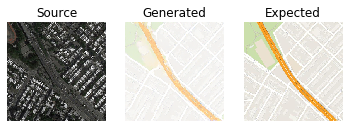

(1, 256, 256, 3)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 8, 8, 3)      0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 8, 512)    2048        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 8, 8, 512)    0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 8, 8, 512)    2359808     leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

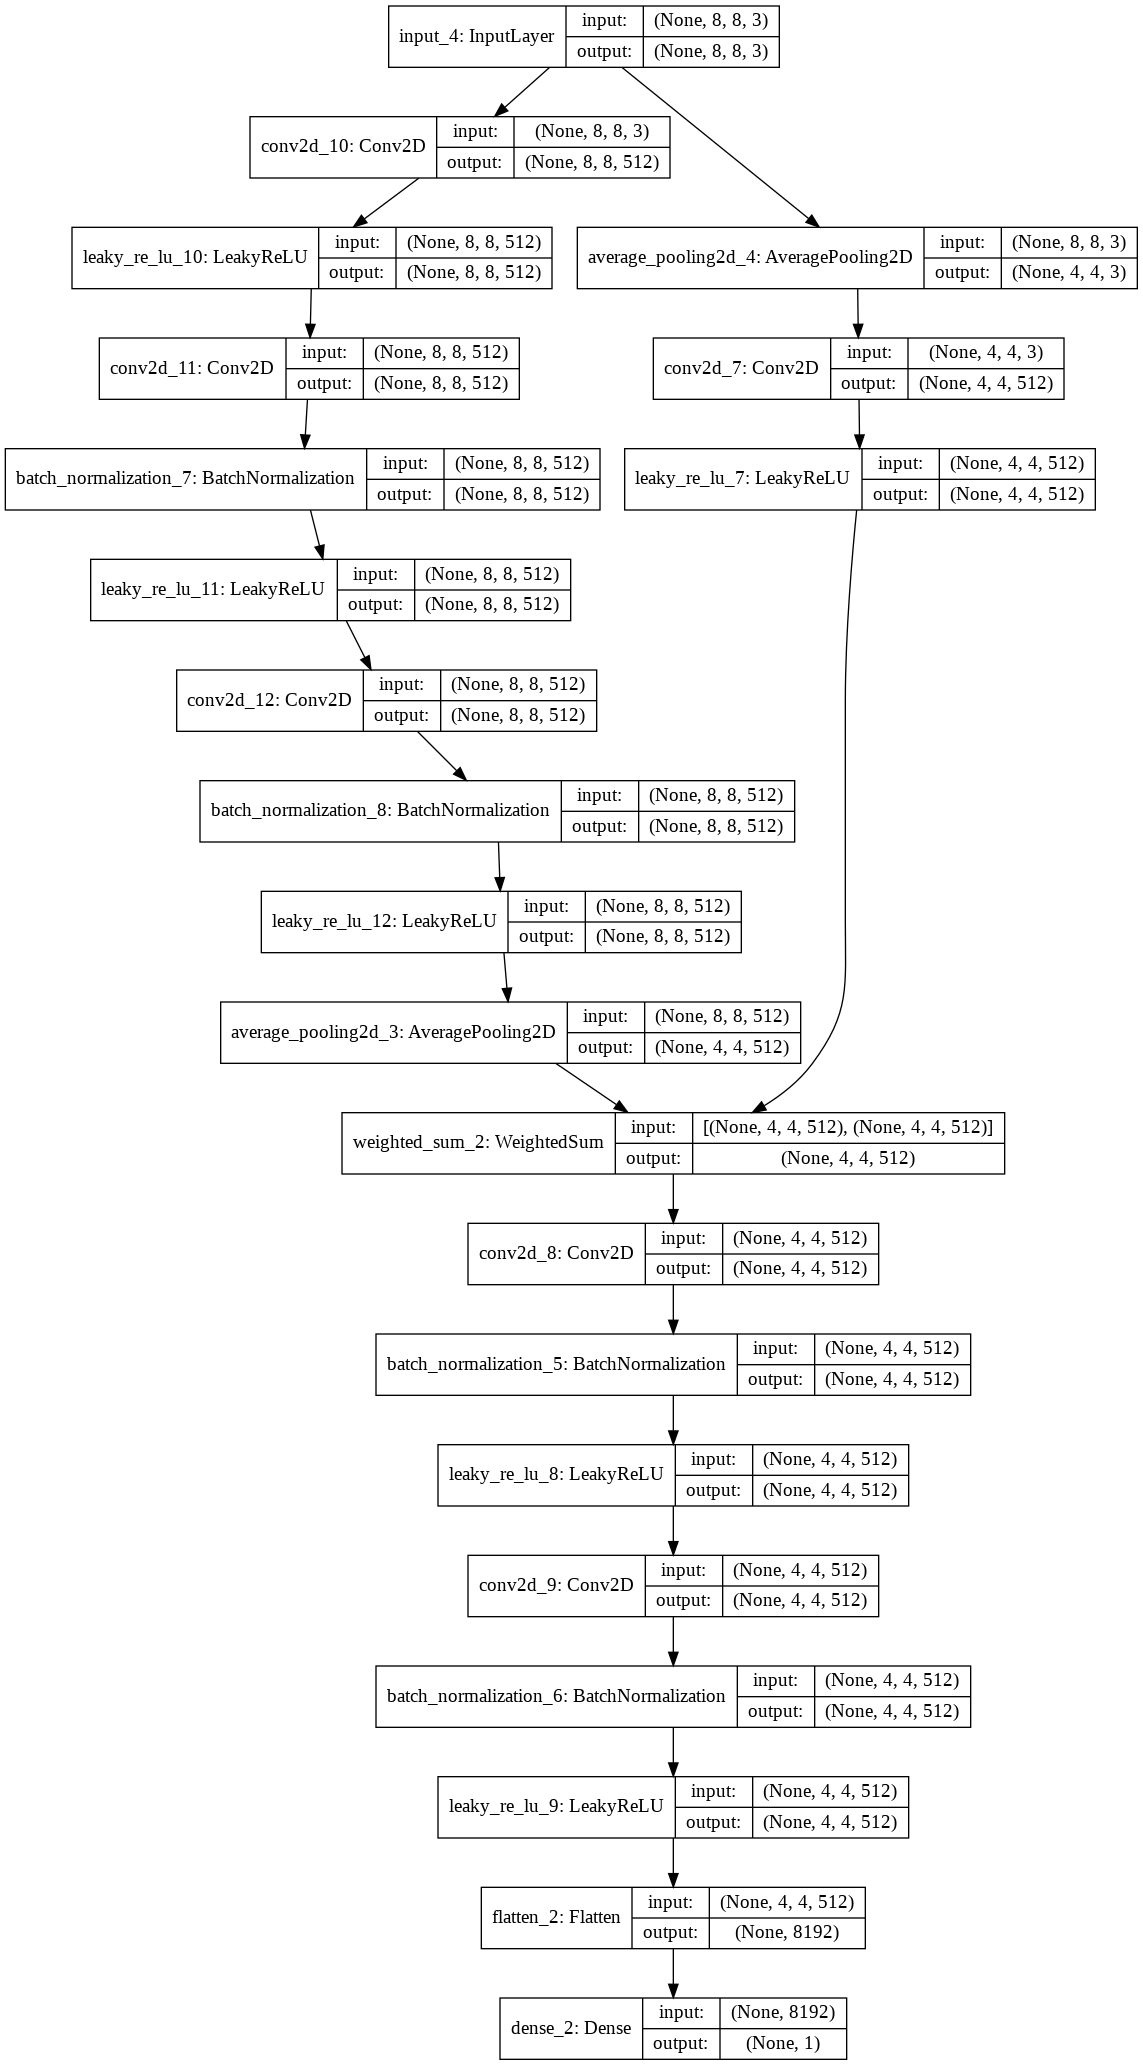